In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install --upgrade numpy pandas matplotlib seaborn scipy

     |████████████████████████████████| 11.2 MB 4.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
df = pd.read_csv('/content/10min.csv')

In [ ]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [ ]:
print(len(df))

9879


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

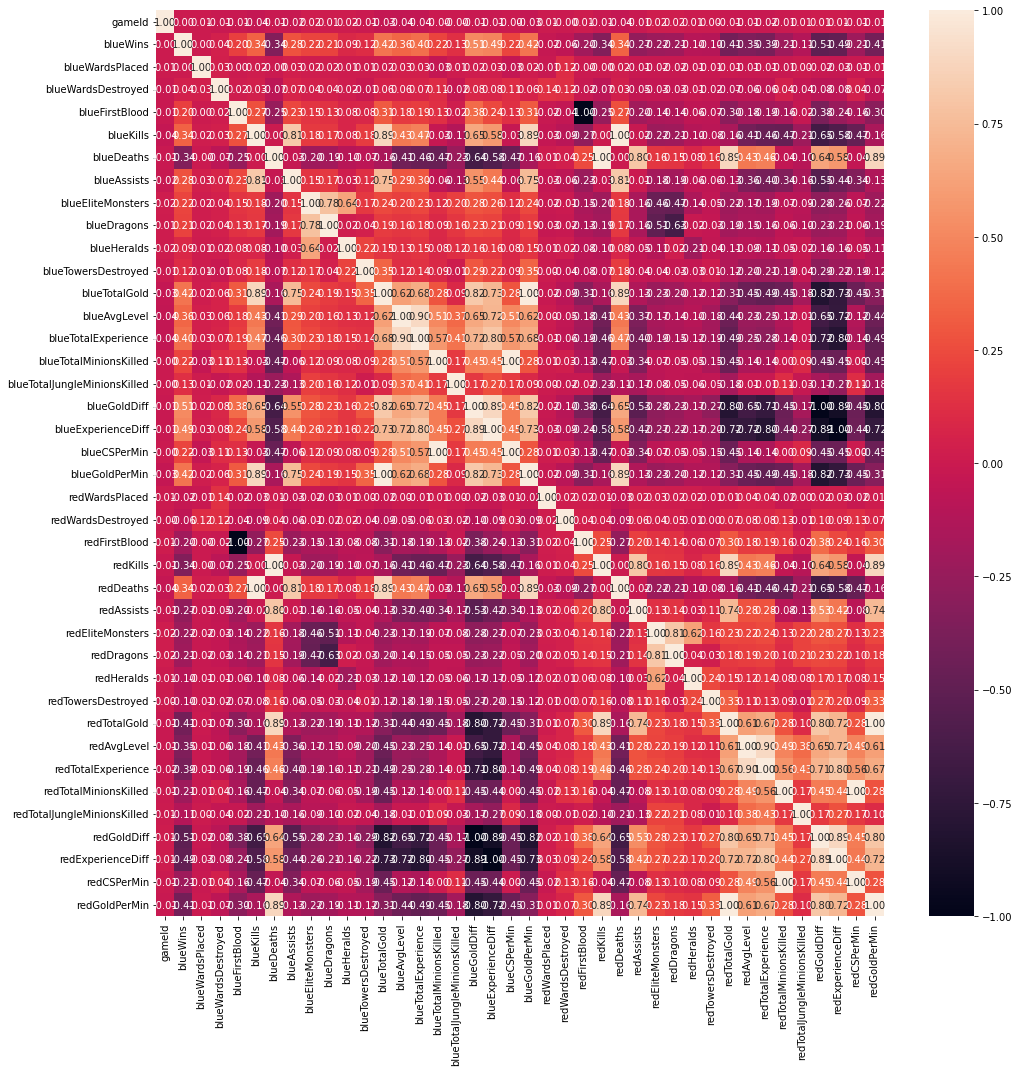

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(),annot=True, fmt='.2f')
plt.tight_layout()

## EDA 파트
Feature들 중에 쓸만한 것과 거를것들을 선정해보자.

### 0) gameid의 경우 특별한 역할이 없으므로 삭제
### 1) 블루팀/레드팀으로 나뉘어있어 무의미한 것들이 많이 있다

bluedeath와 redkill, bluekill과 reddeath, bluefirstblood와 redfirstblood는 완전 같은 Feature
히트맵을 확인하면 상관계수가 1이므로 삭제해도 무방하다는 것을 알 수 있다.

또한 '블루가 승리 = 레드는 패배'라는 가정에 의해 대부분의 레드
관련 정보는 삭제해도 무방

### 2) 합 등 수식으로 요약할 수 있는 feature

미니언 킬, 정글 킬 등의 정보는 total gold의 factor이고, 단순 total gold보다 양팀의 gold diff가 더 직관적이므로 하나로 요약

마찬가지로 blueAvgLevel, blueTotalexp등도 blueexpdiff로 요약 가능

Elitemonster는 단순 Dragon + Heralds의 합이므로 삭제 가능

### 3) 상관관계가 낮은 feature에 대한 삭제

WardsPlaced 및 WardsDestroyed의 경우 상관관계가 낮긴하지만
Wardsplaced는 아래 가정에 의해 다른 전처리 과정을 거쳐서
확인을 해보려고 한다.

### 4) kill, death, assists에 관한 feature

롤에서 킬, 데스, 어시는 다양한 지표로 사용한다. 때문에 이 지표들을 단순히 확인하지 않고 적절하게 수식으로 변환해서 더 영향을 주는 하나의 feature로 요약하고자 한다.

#### 4-1) 단순 킬데스로 본 K-D
#### 4-2) 흔히 사용되는 KDA(K+A)/D
#### 4-3) 골드차이에 가까운 K+0.5A-D

을 상관분석해 더 좋은 feature하나로 바꾸고자 한다.


#### 과연 진영간 승률차가 있을까?

패배 = 0 승리 =1로 코딩
대충봐도 큰 영향이 없어보임

일부러 그렇게 표집했을 가능성도 있다고 생각함

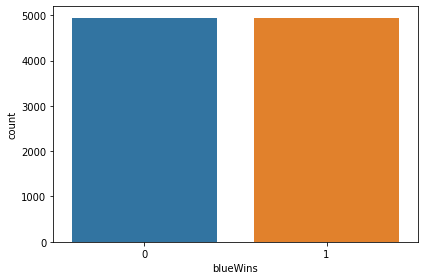

In [ ]:
sns.countplot(x=df['blueWins'])
plt.tight_layout()

<AxesSubplot:>

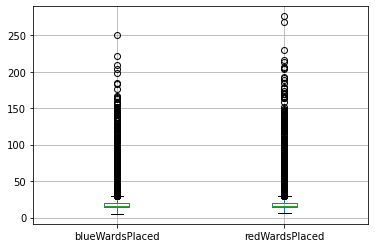

In [ ]:
df.boxplot(['blueWardsPlaced', 'redWardsPlaced'])

#### 와드개수와 관련된 변수
한 눈에봐도 제대로된 편차를 알 수 없다.

서렌 혹은 트롤시 집앞에 와드꽃을 만들기 때문으로 보임


In [ ]:
blueward = df[['blueWardsPlaced', 'blueWins', 'redWardsPlaced']]
blueward2 = df[['blueWardsPlaced', 'blueWins']]

In [ ]:
a = np.mean(blueward.blueWardsPlaced)
b = np.std(blueward.blueWardsPlaced)
print(f'블루팀 와드 평균 : {a:.2f}, 블루팀 와드 편차 : {b:.2f}')

블루팀 와드 평균 : 22.29, 블루팀 와드 편차 : 18.02


In [ ]:
blueward.describe()

,blueWardsPlaced,blueWins,redWardsPlaced
count,9879.000000,9879.000000,9879.000000
mean,22.288288,0.499038,22.367952
std,18.019177,0.500024,18.457427
min,5.000000,0.000000,6.000000
25%,14.000000,0.000000,14.000000
50%,16.000000,0.000000,16.000000
75%,20.000000,1.000000,20.000000
max,250.000000,1.000000,276.000000


#### 블루와드의 평균, 레드와드의 평균이 거의 같다.
따라서 와드의 수는 승패에 전혀 영향을 미치지 않는 다는 것을 알 수 있다. 

이는 초기 10분 내의 시야정보가 크게 중요하지 않기 때문이며,
상위권 티어에서는 상황이 되면 다들 적절하게 와드를 사용하기 때문에 이로인한 편차가 거의 없는 점으로 해석 할 수 있다.

In [ ]:
kda.corr()

,blueWins,blueKills,blueDeaths,KD,blueAssists,KAD,KDA.1,KAD2
blueWins,1.000000,0.337358,-0.339297,0.479379,0.276685,0.454906,0.356967,0.424118
blueKills,0.337358,1.000000,0.004044,0.714854,0.813667,0.822438,0.463757,0.852929
blueDeaths,-0.339297,0.004044,1.000000,-0.696377,-0.026372,-0.525914,-0.576934,-0.409648
KD,0.479379,0.714854,-0.696377,1.000000,0.602396,0.958009,0.736267,0.898590
blueAssists,0.276685,0.813667,-0.026372,0.602396,1.000000,0.805973,0.501433,0.891547
KAD,0.454906,0.822438,-0.525914,0.958009,0.805973,1.000000,0.726154,0.986675
KDA.1,0.356967,0.463757,-0.576934,0.736267,0.501433,0.726154,1.000000,0.693436
KAD2,0.424118,0.852929,-0.409648,0.898590,0.891547,0.986675,0.693436,1.000000


### KDA 관련 지표
#### 4-1) 단순 킬데스로 본 K-D (KD)
#### 4-2) 흔히 사용되는 KDA(K+A)/D (KDA)
#### 4-3) 골드차이에 가까운 K+0.5A-D (KAD.1)
#### 4-4) 킬어시합과 데스의 차 K+A-D (KAD2)

상관계수는 KD가 제일 높았으나 Assist정보와
보편적으로 사용되는 것을 감안해

KDA를 kill, death, assist의 요약 feature로 사용함

KDA에서 D가 0인 경우는 10으로 일괄 변경하였다.


In [38]:
EDA = pd.read_csv('/content/EDA.csv')

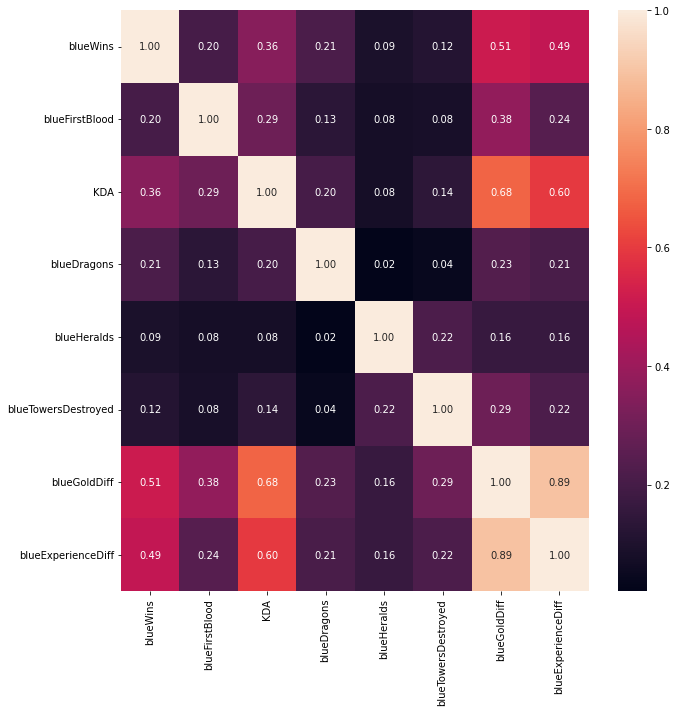

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = EDA.corr(),annot=True, fmt='.2f')
plt.tight_layout()

## 시각화 파트

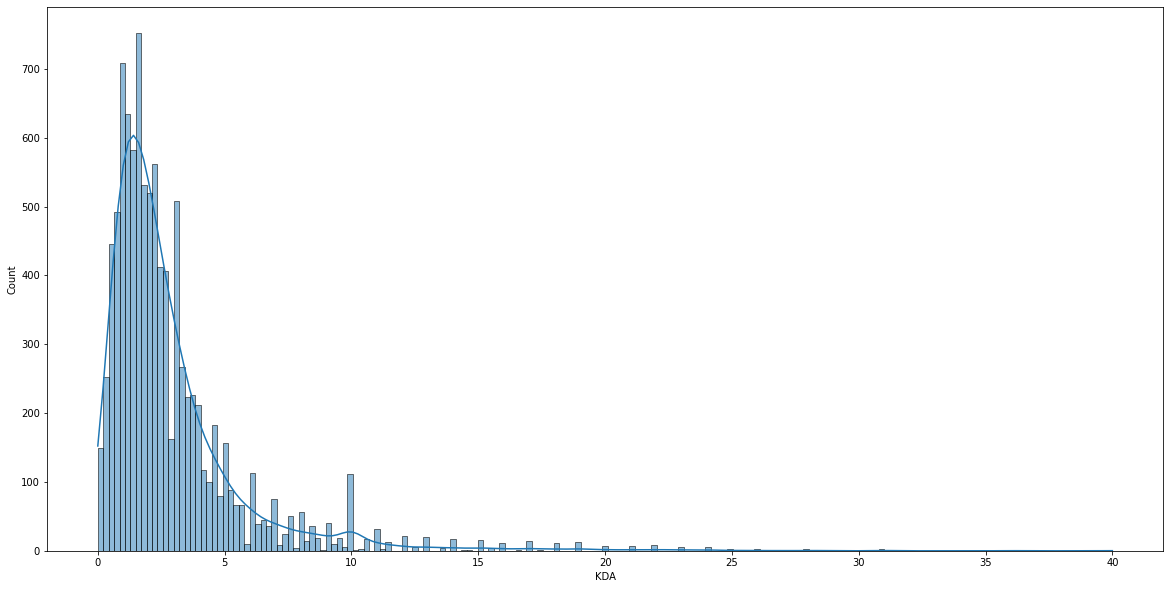

In [ ]:
plt.figure(figsize=(20,10))
sns.histplot(EDA['KDA'], kde=True)
plt.show()

<AxesSubplot:xlabel='KDA', ylabel='blueWins'>

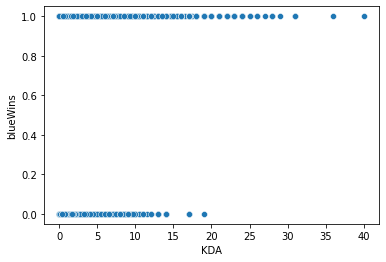

In [ ]:
sns.scatterplot(x='KDA', y='blueWins', data=EDA)

In [ ]:
kdawin=EDA[['KDA','blueWins']]

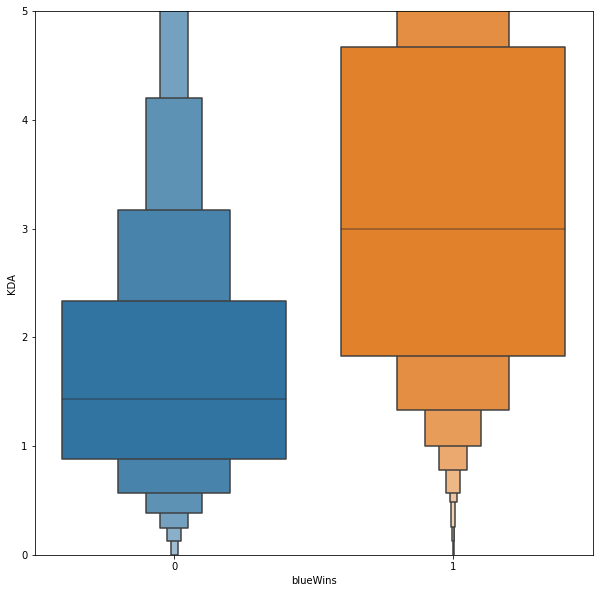

In [ ]:
plt.figure(figsize=(10,10))
sns.boxenplot(x='blueWins', y='KDA', data=kdawin)
plt.ylim([0, 5])
plt.show()

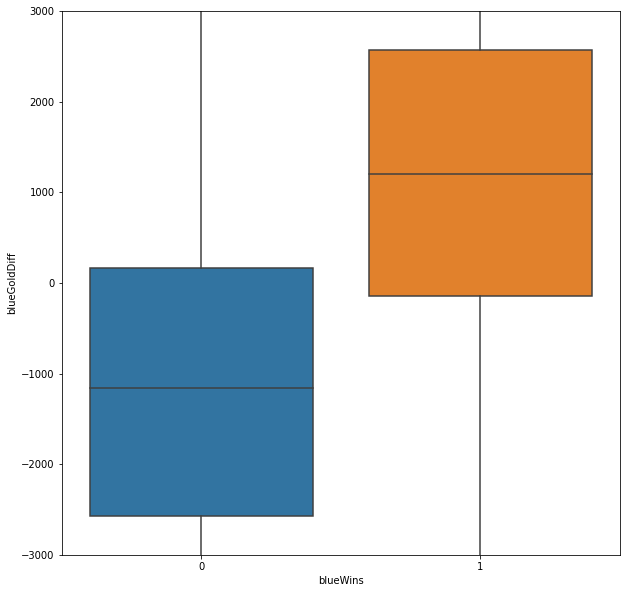

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x='blueWins', y='blueGoldDiff', data=EDA)
plt.ylim([-3000, 3000])
plt.show()

In [ ]:
EDA.columns

Index(['blueWins', 'blueFirstBlood', 'KDA', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueGoldDiff', 'blueExperienceDiff'],
      dtype='object')

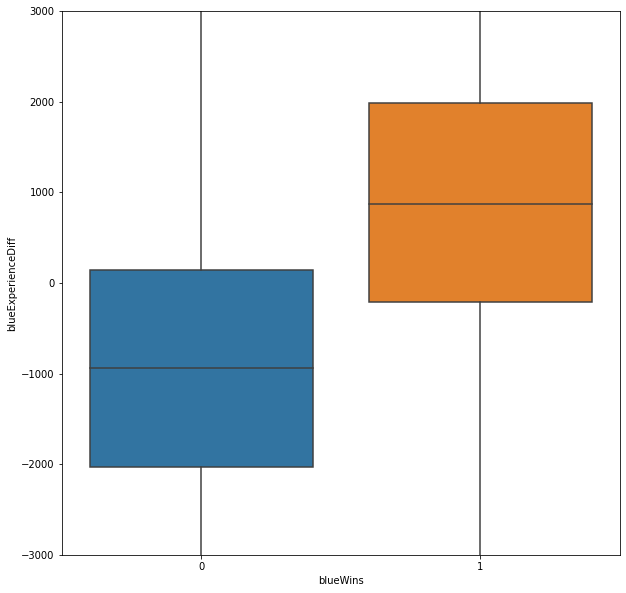

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x='blueWins', y='blueExperienceDiff', data=EDA)
plt.ylim([-3000, 3000])
plt.show()

In [ ]:
EDA['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

In [9]:
fb = EDA.loc[EDA.blueFirstBlood == 0]

In [10]:
fb.head()

,blueWins,blueFirstBlood,KDA,blueDragons,blueHeralds,blueTowersDestroyed,blueGoldDiff,blueExperienceDiff
1,0,0,2.00,0,0,0,-2908,-1173
2,0,0,1.00,1,0,0,-1172,-1033
3,0,0,1.80,0,1,0,-1321,-7
4,0,0,2.00,0,0,0,-1004,230
5,1,0,3.67,1,0,0,698,101


In [11]:
fb['blueWins'].value_counts()

0    2949
1    1943
Name: blueWins, dtype: int64

In [12]:
fb2 = EDA.loc[EDA.blueFirstBlood == 1]

In [13]:
fb2['blueWins'].value_counts()

1    2987
0    2000
Name: blueWins, dtype: int64

In [23]:
bluewinnfb = [1943, 2949]
bluewinfb = [2987, 2000]
colors = ['blue', 'red']
label = ['bluewin', 'redwin']

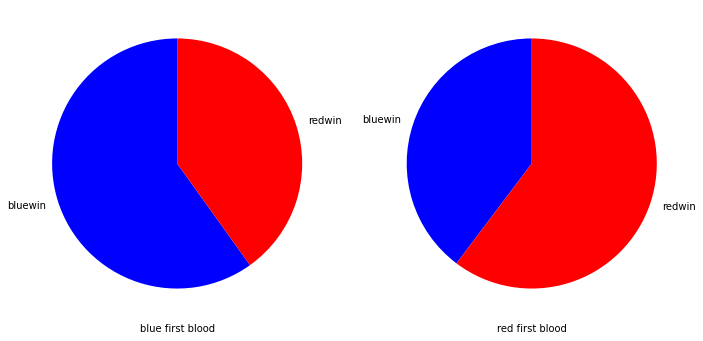

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.pie(bluewinfb, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue first blood')

plt.subplot(1,2,2)
plt.pie(bluewinnfb, labels=label, startangle = 90, colors=colors)
plt.xlabel('red first blood')

plt.tight_layout()

In [32]:
BDK = EDA.loc[EDA.blueDragons == 1]

In [33]:
BDK['blueWins'].value_counts()

1    2292
0    1284
Name: blueWins, dtype: int64

In [34]:
BDnK = EDA.loc[EDA.blueDragons == 0]

In [35]:
BDnK['blueWins'].value_counts()

0    3665
1    2638
Name: blueWins, dtype: int64

In [36]:
bluedragonkill = [2292, 1284]
bluedragonnotkill = [2638, 3665]

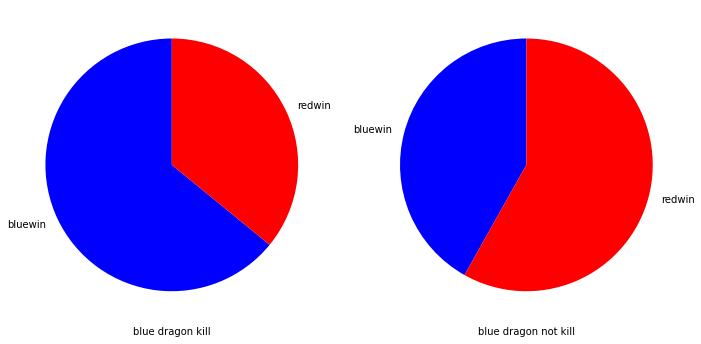

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.pie(bluedragonkill, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue dragon kill')

plt.subplot(1,2,2)
plt.pie(bluedragonnotkill, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue dragon not kill')

plt.tight_layout()

In [43]:
BHK = EDA.loc[EDA.blueHeralds == 1]

In [47]:
BHK['blueWins'].value_counts()

1    1105
0     752
Name: blueWins, dtype: int64

In [48]:
BHnK = EDA.loc[EDA.blueHeralds == 0]

In [49]:
BHnK['blueWins'].value_counts()

0    4197
1    3825
Name: blueWins, dtype: int64

In [50]:
blueheraldkill = [1105, 752]
blueheraldnotkill = [3825, 4197]

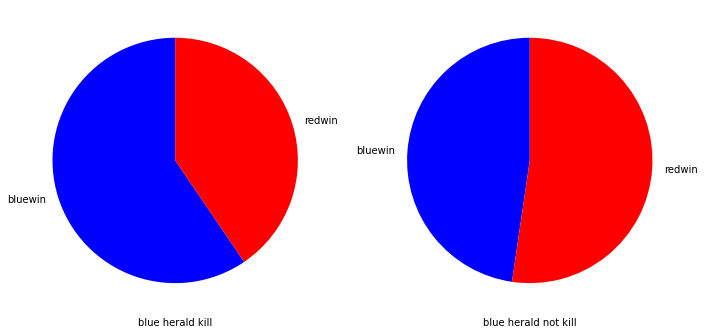

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.pie(blueheraldkill, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue herald kill')

plt.subplot(1,2,2)
plt.pie(blueheraldnotkill, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue herald not kill')

plt.tight_layout()

In [54]:
BTD = EDA.loc[EDA.blueTowersDestroyed > 0]

In [55]:
BTD['blueWins'].value_counts()

1    350
0    114
Name: blueWins, dtype: int64

In [56]:
BTnD = EDA.loc[EDA.blueTowersDestroyed == 0]

In [57]:
BTnD['blueWins'].value_counts()

0    4835
1    4580
Name: blueWins, dtype: int64

In [59]:
bluetowerdest = [350, 114]
bluetowernotdest = [4580, 4835]

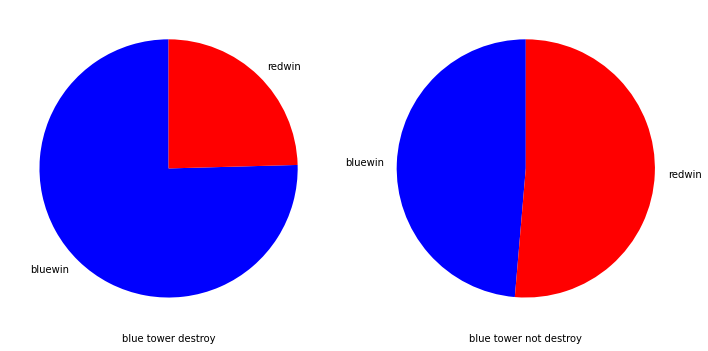

In [60]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.pie(bluetowerdest, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue tower destroy')

plt.subplot(1,2,2)
plt.pie(bluetowernotdest, labels=label, startangle = 90, colors=colors)
plt.xlabel('blue tower not destroy')

plt.tight_layout()